In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [10]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns
from flax.training import train_state
from jax import random

from neurovae import MLPVAE, bce_loss, gaussian_kld, load_mnist, plot_digits

from plot_utils import plot_comparison

sns.set_theme(context="paper", style="darkgrid", rc={"axes.facecolor": "0.96"})
fontsize = "x-large"
params = {
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.handlelength": 2,
}
plt.rcParams.update(params)

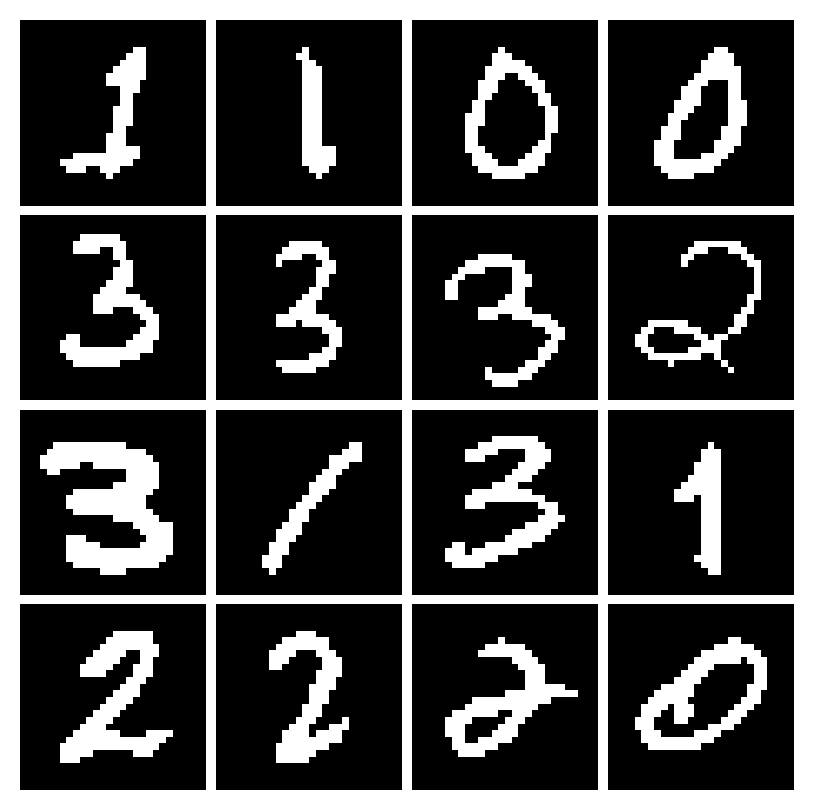

In [3]:
hidden_dim = 500
latent_dim = 20
output_dim = 784
batch_size = 64
epochs = 50
seed = 42

batches, ds_test = load_mnist(
    batch_size=batch_size,
    drop_remainder=True,
    select_digits=[0, 1, 2, 3],
    as_supervised=False,
    binarized=True,
    shuffle=True,
    shuffle_seed=42,
)

# set values for learning rate scheduler
total_steps = len(batches) * epochs
init_lr = 1e-3
alpha_lr = 1e-2

ds_test = jax.device_put(ds_test)

plot_digits(batches[0][:16])
plt.show()

In [4]:
def model():
    return MLPVAE(hidden_dim, latent_dim, output_dim)


def init_model(rng):
    rng, init_key = random.split(rng)

    initial_variables = jnp.ones((batch_size, output_dim), jnp.float32)
    params = model().init(init_key, initial_variables, rng)["params"]
    del initial_variables, init_key

    lr_schedule = optax.cosine_decay_schedule(init_lr, decay_steps=total_steps, alpha=alpha_lr)
    optimizer = optax.chain(optax.clip(1.0), optax.adamw(lr_schedule, nesterov=True))

    state = train_state.TrainState.create(
        apply_fn=model().apply,
        params=params,
        tx=optimizer,
    )
    return rng, state


def compute_metrics(recon_x, x, mean, logvar):
    bce = bce_loss(recon_x, x).mean()  # mean over batch
    kld = gaussian_kld(mean, logvar).mean()  # mean over batch
    elbo = bce + kld
    return {"elbo": elbo, "bce": bce, "kld": kld}


@jax.jit
def train_step(state, batch, z_rng):

    def loss_fn(params):
        recon_x, mean, logvar = model().apply({"params": params}, batch, z_rng)
        bce = bce_loss(recon_x, batch).mean()
        kld = gaussian_kld(mean, logvar).mean()
        elbo = bce + kld
        return elbo

    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)


@jax.jit
def eval_f(params, images, z, z_rng):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)

        recon_images_compare = nn.sigmoid(recon_images[:8])
        comparison = jnp.concatenate(
            [
                images[:8].reshape(-1, 28, 28, 1),
                recon_images_compare.reshape(-1, 28, 28, 1),
            ]
        )

        generate_images = vae.generate(z, assumption="bernoulli")
        generate_images = generate_images.reshape(-1, 28, 28, 1)
        metrics = compute_metrics(recon_images, images, mean, logvar)
        return metrics, comparison, generate_images

    return nn.apply(eval_model, model())({"params": params})

In [5]:
rng = random.key(seed)
rng, state = init_model(rng)

rng, z_key, eval_rng = random.split(rng, 3)

z = random.normal(z_key, (batch_size, latent_dim))  # prior
del z_key

epoch_metrics = []
for epoch in range(epochs):
    for batch in batches:
        rng, key = random.split(rng)
        state = train_step(state, batch, key)

    metrics, comparison, samples = eval_f(state.params, ds_test, z, eval_rng)
    metrics["epoch"] = epoch + 1
    epoch_metrics.append(metrics)
    print(f"epoch: {epoch + 1}, ELBO: {metrics['elbo']:.4f}, BCE: {metrics['bce']:.4f}, KLD: {metrics['kld']:.4f}")

epoch: 1, ELBO: 99.8508, BCE: 74.9244, KLD: 24.9264
epoch: 2, ELBO: 91.3362, BCE: 65.0761, KLD: 26.2600
epoch: 3, ELBO: 88.0727, BCE: 60.8158, KLD: 27.2569
epoch: 4, ELBO: 86.0724, BCE: 59.6053, KLD: 26.4670
epoch: 5, ELBO: 84.8246, BCE: 56.9989, KLD: 27.8257
epoch: 6, ELBO: 83.6365, BCE: 56.4755, KLD: 27.1610
epoch: 7, ELBO: 82.8804, BCE: 55.1831, KLD: 27.6973
epoch: 8, ELBO: 82.5906, BCE: 54.6886, KLD: 27.9019
epoch: 9, ELBO: 81.9626, BCE: 54.2801, KLD: 27.6825
epoch: 10, ELBO: 81.6135, BCE: 53.7785, KLD: 27.8350
epoch: 11, ELBO: 81.2388, BCE: 53.4183, KLD: 27.8205
epoch: 12, ELBO: 80.8234, BCE: 52.8810, KLD: 27.9424
epoch: 13, ELBO: 80.5470, BCE: 52.5288, KLD: 28.0182
epoch: 14, ELBO: 80.4116, BCE: 52.5594, KLD: 27.8522
epoch: 15, ELBO: 80.2607, BCE: 51.9862, KLD: 28.2745
epoch: 16, ELBO: 79.9361, BCE: 51.4794, KLD: 28.4568
epoch: 17, ELBO: 79.6919, BCE: 51.1365, KLD: 28.5554
epoch: 18, ELBO: 79.4310, BCE: 51.0558, KLD: 28.3752
epoch: 19, ELBO: 79.3578, BCE: 50.6354, KLD: 28.7224
ep

In [6]:
df = pd.DataFrame(epoch_metrics)
df

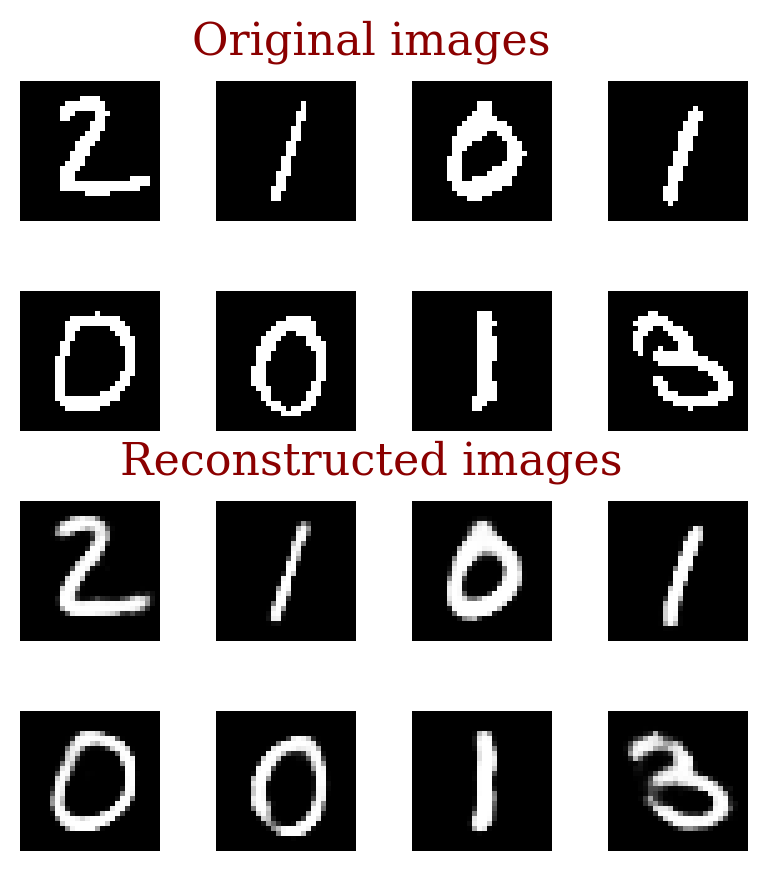

In [9]:
plot_comparison(comparison)

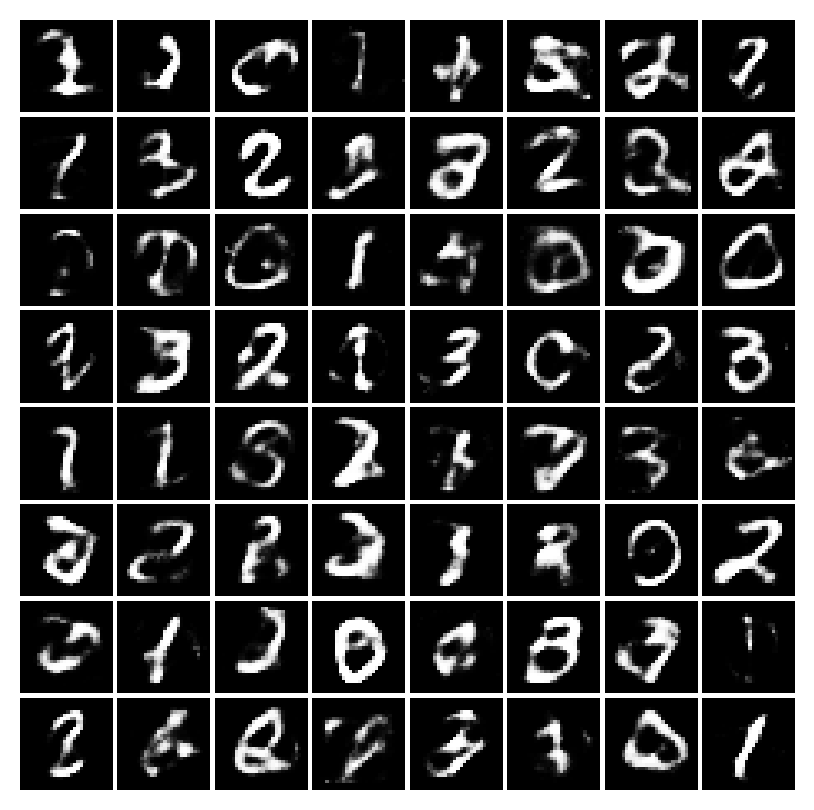

In [12]:
plot_digits(samples)